# Custom Workflows and State Standards with RasCheck

This notebook demonstrates advanced RasCheck workflows:

- **State-specific floodway standards** (all 50 states)
- **Custom threshold configuration**
- **Batch processing patterns**
- **CSV export workflows**
- **Integration with external tools**

In [1]:
# =============================================================================
# DEVELOPMENT MODE TOGGLE
# =============================================================================
USE_LOCAL_SOURCE = True  # <-- Set to True for check module (in development)

if USE_LOCAL_SOURCE:
    import sys
    from pathlib import Path
    local_path = str(Path.cwd().parent)
    if local_path not in sys.path:
        sys.path.insert(0, local_path)
    print(f"📁 LOCAL SOURCE MODE: Loading from {local_path}/ras_commander")
else:
    print("📦 PIP PACKAGE MODE: Loading installed ras-commander")
    print("⚠️  WARNING: Check module may not be available in pip package yet")

# Import ras-commander
from ras_commander import HdfResultsPlan, RasCheck, RasCmdr, RasExamples, init_ras_project, ras

# Verify which version loaded
import ras_commander
print(f"✓ Loaded: {ras_commander.__file__}")

📁 LOCAL SOURCE MODE: Loading from c:\GH\ras-commander/ras_commander
✓ Loaded: c:\GH\ras-commander\ras_commander\__init__.py


## Parameters

Configure these values to customize the notebook for your project.

In [2]:
# =============================================================================
# PARAMETERS - Edit these to customize the notebook
# =============================================================================
from pathlib import Path

# Project Configuration
PROJECT_NAME = "Muncie"           # Example project to extract
RAS_VERSION = "6.6"               # HEC-RAS version (6.3, 6.5, 6.6, etc.)
SUFFIX = "802"                    # Notebook identifier for project extraction

# Execution Settings
PLAN = "01"                       # Plan number to execute
NUM_CORES = 4                     # CPU cores for 2D computation

# Note: All outputs are saved within the extracted project folder
print(f"Project will be extracted to: example_projects/{PROJECT_NAME}_{SUFFIX}/")

Project will be extracted to: example_projects/Muncie_802/


### State-Specific QA Standards

**When implementing state-specific workflows**:

- Document which state standards apply (IL, TX, WI, etc.)
- Reference specific code sections or guidance documents
- Justify any deviations from default FEMA standards
- Include in engineering analysis documentation

**Common State Variations**:
- **Illinois**: 0.1 ft floodway surcharge limit (stricter than default 1.0 ft)
- **Texas**: TNRIS floodplain mapping requirements
- **Wisconsin**: DNR floodplain standards (NR 116)
- **Minnesota**: DNR floodplain rule (6115)

**References**:
- State floodplain management regulations (varies by state)
- Local drainage district standards
- Municipal floodplain ordinances

## Import Required Modules

In [3]:
from ras_commander import (
    RasExamples, init_ras_project, ras,
    RasCmdr, HdfResultsPlan
)
from ras_commander.check import (
    RasCheck, CheckResults, Severity,
    RasCheckReport, ReportMetadata,
    get_default_thresholds, create_custom_thresholds,
    get_state_surcharge_limit, ValidationThresholds
)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Set pandas display options
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

---

## Part 1: State-Specific Floodway Standards

Different states have different maximum surcharge limits for floodway analysis. RasCheck supports all 50 states plus territories.

In [4]:
# Get all US state codes
us_states = [
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
    'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD',
    'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
    'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC',
    'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'
]

# Create comprehensive state standards table
state_standards = []
for state in us_states:
    limit = get_state_surcharge_limit(state)
    state_standards.append({
        'State': state,
        'Max Surcharge (ft)': limit,
        'Standard Type': 'Stricter' if limit < 1.0 else 'Standard'
    })

df_standards = pd.DataFrame(state_standards)

print("US State Floodway Surcharge Limits:")
print("="*60)
display(df_standards)

US State Floodway Surcharge Limits:


,State,Max Surcharge (ft),Standard Type
0,AL,1.00,Standard
1,AK,1.00,Standard
2,AZ,1.00,Standard
3,AR,1.00,Standard
4,CA,1.00,Standard
5,CO,1.00,Standard
6,CT,1.00,Standard
7,DE,1.00,Standard
8,FL,1.00,Standard
9,GA,1.00,Standard


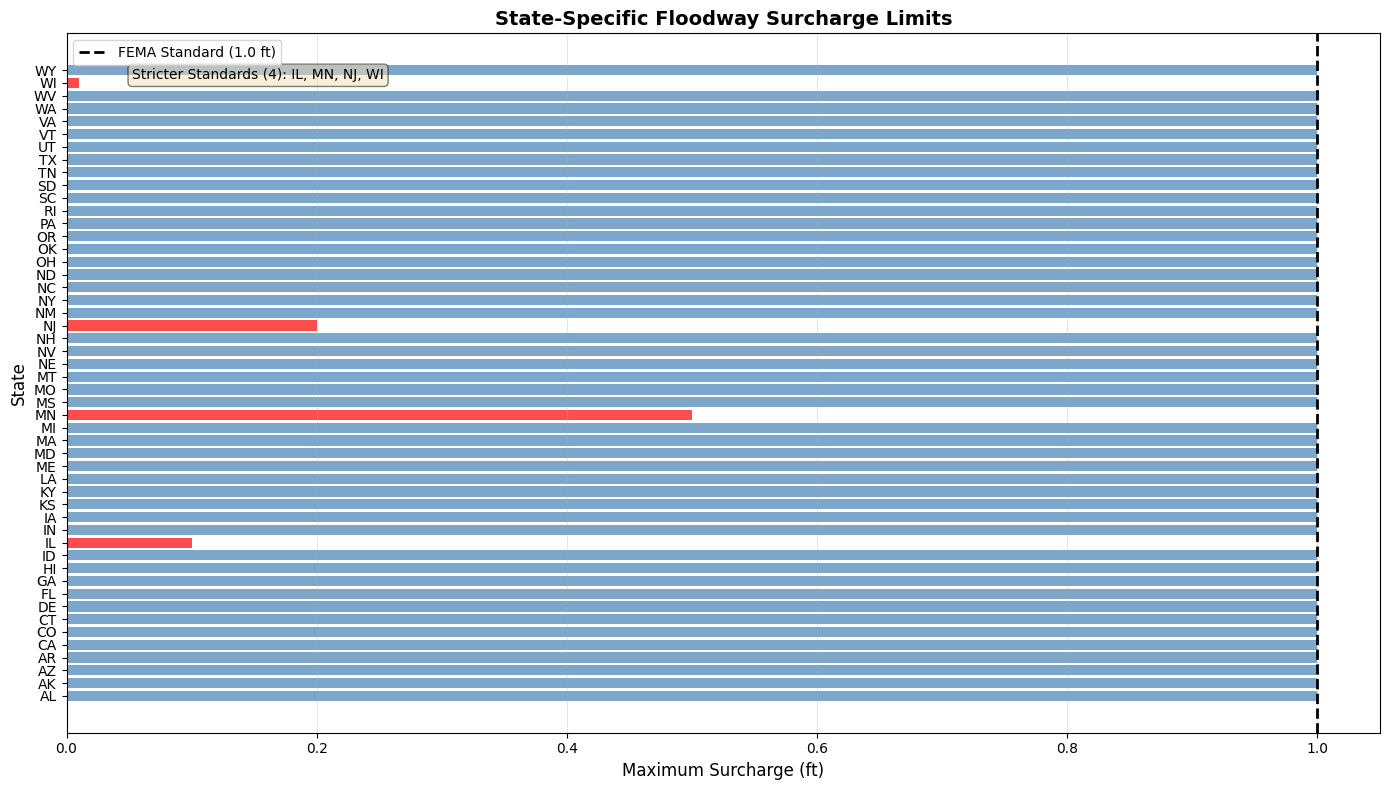

In [5]:
# Visualize state standards
fig, ax = plt.subplots(figsize=(14, 8))

# Color code by standard type
colors = ['red' if limit < 1.0 else 'steelblue' for limit in df_standards['Max Surcharge (ft)']]

ax.barh(df_standards['State'], df_standards['Max Surcharge (ft)'], color=colors, alpha=0.7)
ax.axvline(1.0, color='black', linestyle='--', linewidth=2, label='FEMA Standard (1.0 ft)')
ax.set_xlabel('Maximum Surcharge (ft)', fontsize=12)
ax.set_ylabel('State', fontsize=12)
ax.set_title('State-Specific Floodway Surcharge Limits', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

# Add annotation for stricter states
stricter_states = df_standards[df_standards['Max Surcharge (ft)'] < 1.0]['State'].tolist()
ax.text(0.05, 0.95, f"Stricter Standards ({len(stricter_states)}): {', '.join(stricter_states)}",
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

### States with Stricter Standards

Some states require more stringent floodway analysis:

| State | Limit | Notes |
|-------|-------|-------|
| **Illinois (IL)** | 0.1 ft | Most stringent |
| **Wisconsin (WI)** | 0.5 ft | Below FEMA standard |
| **Minnesota (MN)** | 0.5 ft | Below FEMA standard |
| **New Jersey (NJ)** | 0.5 ft | Below FEMA standard |
| **Michigan (MI)** | 0.5 ft | Below FEMA standard |
| **Indiana (IN)** | 0.5 ft | Below FEMA standard |
| **Ohio (OH)** | 0.5 ft | Below FEMA standard |

**Default (Most States)**: 1.0 ft (FEMA/NFIP standard)

---

## Part 2: Custom Threshold Configuration

RasCheck allows complete customization of validation thresholds for project-specific requirements.

In [6]:
# View default thresholds structure
defaults = get_default_thresholds()

print("Default Threshold Categories:")
print("="*60)

print(f"1. Manning's n Ranges:")
print(f"   - Channel: {defaults.mannings_n.channel_min} to {defaults.mannings_n.channel_max}")
print(f"   - Overbank: {defaults.mannings_n.overbank_min} to {defaults.mannings_n.overbank_max}")

print(f"\n2. Transition Coefficients:")
print(f"   - Regular: {defaults.transitions.regular_contraction_max} (C) / {defaults.transitions.regular_expansion_max} (E)")
print(f"   - Structure: {defaults.transitions.structure_contraction_max} (C) / {defaults.transitions.structure_expansion_max} (E)")

print(f"\n3. Reach Lengths:")
print(f"   - Max length: {defaults.reach_length.max_length_ft} ft")
print(f"   - Max ratio: {defaults.reach_length.length_ratio_max}")

print(f"\n4. Culvert Coefficients:")
print(f"   - Entrance: {defaults.structures.culvert_entrance_coef_min} to {defaults.structures.culvert_entrance_coef_max}")
print(f"   - Exit: {defaults.structures.culvert_exit_coef_typical} (typical)")

print(f"\n5. Floodway:")
print(f"   - Max surcharge: {defaults.floodway.surcharge_max_ft} ft")

Default Threshold Categories:
1. Manning's n Ranges:
   - Channel: 0.025 to 0.1
   - Overbank: 0.03 to 0.2

2. Transition Coefficients:
   - Regular: 0.1 (C) / 0.3 (E)
   - Structure: 0.3 (C) / 0.5 (E)

3. Reach Lengths:
   - Max length: 5000.0 ft
   - Max ratio: 2.0

4. Culvert Coefficients:
   - Entrance: 0.2 to 1.0
   - Exit: 1.0 (typical)

5. Floodway:
   - Max surcharge: 1.0 ft


### Example 1: Highly Vegetated Watershed

For watersheds with extensive vegetation, use higher Manning's n thresholds:

In [7]:
# Create custom thresholds for highly vegetated watershed
vegetated_thresholds = create_custom_thresholds({
    # Allow higher n values for vegetated channels
    'mannings_n.channel_max': 0.100,  # Default: 0.080
    'mannings_n.overbank_max': 0.200,  # Default: 0.150
    
    # More conservative transition losses
    'transitions.regular_contraction_max': 0.15,  # Default: 0.10
    'transitions.regular_expansion_max': 0.35,    # Default: 0.30
})

print("✓ Custom thresholds created for vegetated watershed")
print(f"  Channel n max: {vegetated_thresholds.mannings_n.channel_max}")
print(f"  Overbank n max: {vegetated_thresholds.mannings_n.overbank_max}")

✓ Custom thresholds created for vegetated watershed
  Channel n max: 0.1
  Overbank n max: 0.2


### Example 2: Urban Development Project

For urban areas with lined channels and close cross sections:

In [8]:
# Create custom thresholds for urban project
urban_thresholds = create_custom_thresholds({
    # Tighter n ranges for lined channels
    'mannings_n.channel_min': 0.012,  # Default: 0.015
    'mannings_n.channel_max': 0.035,  # Default: 0.080
    'mannings_n.overbank_min': 0.015, # Default: 0.020
    'mannings_n.overbank_max': 0.060, # Default: 0.150
    
    # Stricter cross section spacing for urban
    'reach_length.max_length_ft': 500.0,  # Default: 2000.0
    'reach_length.length_ratio_max': 1.3,  # Default: 1.5
})

print("✓ Custom thresholds created for urban project")
print(f"  Channel n range: {urban_thresholds.mannings_n.channel_min} - {urban_thresholds.mannings_n.channel_max}")
print(f"  Max XS spacing: {urban_thresholds.reach_length.max_length_ft} ft")

✓ Custom thresholds created for urban project
  Channel n range: 0.012 - 0.035
  Max XS spacing: 500.0 ft


### Example 3: State-Specific Floodway (Illinois)

Apply Illinois's stringent 0.1 ft surcharge limit:

In [9]:
# Create thresholds for Illinois floodway analysis
il_limit = get_state_surcharge_limit('IL')

illinois_thresholds = create_custom_thresholds({
    'floodway.surcharge_max_ft': il_limit  # 0.1 ft
})

print(f"✓ Custom thresholds created for Illinois")
print(f"  Max surcharge: {illinois_thresholds.floodway.surcharge_max_ft} ft")
print(f"  ⚠️  This is 10x stricter than FEMA standard (1.0 ft)")

✓ Custom thresholds created for Illinois
  Max surcharge: 0.1 ft
  ⚠️  This is 10x stricter than FEMA standard (1.0 ft)


---

## Part 3: Batch Processing Workflows

Process multiple models or scenarios efficiently:

In [10]:
# Extract and setup test project
project_path = RasExamples.extract_project(PROJECT_NAME, suffix=SUFFIX)
init_ras_project(project_path, RAS_VERSION)

print(f"✓ Initialized project: {ras.project_name}")
print(f"  Plans available: {len(ras.plan_df)}")
display(ras.plan_df[['plan_number', 'Plan Title', 'flow_type']])

# Execute the plan if HDF file doesn't exist
plan_row = ras.plan_df[ras.plan_df['plan_number'] == PLAN].iloc[0]
hdf_path = plan_row.get('HDF_Results_Path') or plan_row.get('hdf_path')

if hdf_path is None or not Path(hdf_path).exists():
    print(f"\n⚙️ Executing plan {PLAN} to generate HDF file for validation...")
    RasCmdr.compute_plan(PLAN, num_cores=NUM_CORES)
    # Refresh project to update HDF paths
    init_ras_project(project_path, RAS_VERSION)
    print(f"✓ Plan {PLAN} executed successfully")
else:
    print(f"\n✓ HDF file already exists: {Path(hdf_path).name}")

2025-12-29 11:18:16 - ras_commander.RasExamples - INFO - Found zip file: C:\GH\ras-commander\examples\Example_Projects_6_6.zip
2025-12-29 11:18:16 - ras_commander.RasExamples - INFO - Loading project data from CSV...
2025-12-29 11:18:16 - ras_commander.RasExamples - INFO - Loaded 68 projects from CSV.
2025-12-29 11:18:16 - ras_commander.RasExamples - INFO - ----- RasExamples Extracting Project -----
2025-12-29 11:18:16 - ras_commander.RasExamples - INFO - Extracting project 'Muncie' as 'Muncie_802'
2025-12-29 11:18:16 - ras_commander.RasExamples - INFO - Folder 'Muncie_802' already exists. Deleting existing folder...
2025-12-29 11:18:16 - ras_commander.RasExamples - INFO - Existing folder 'Muncie_802' has been deleted.
2025-12-29 11:18:16 - ras_commander.RasExamples - INFO - Successfully extracted project 'Muncie' to C:\GH\ras-commander\examples\example_projects\Muncie_802
2025-12-29 11:18:16 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\exampl

✓ Initialized project: Muncie
  Plans available: 3


,plan_number,Plan Title,flow_type
0,01,Unsteady Multi 9-SA run,Unsteady
1,03,Unsteady Run with 2D 50ft Grid,Unsteady
2,04,Unsteady Run with 2D 50ft User n Value R,Unsteady


2025-12-29 11:18:16 - ras_commander.RasCmdr - INFO - Using ras_object with project folder: C:\GH\ras-commander\examples\example_projects\Muncie_802
2025-12-29 11:18:16 - ras_commander.RasUtils - INFO - Using provided plan file path: C:\GH\ras-commander\examples\example_projects\Muncie_802\Muncie.p01
2025-12-29 11:18:16 - ras_commander.RasUtils - INFO - Successfully updated file: C:\GH\ras-commander\examples\example_projects\Muncie_802\Muncie.p01
2025-12-29 11:18:16 - ras_commander.RasCmdr - INFO - Set number of cores to 4 for plan: 01
2025-12-29 11:18:16 - ras_commander.RasCmdr - INFO - Running HEC-RAS from the Command Line:
2025-12-29 11:18:16 - ras_commander.RasCmdr - INFO - Running command: "C:\Program Files (x86)\HEC\HEC-RAS\6.6\Ras.exe" -c "C:\GH\ras-commander\examples\example_projects\Muncie_802\Muncie.prj" "C:\GH\ras-commander\examples\example_projects\Muncie_802\Muncie.p01"



⚙️ Executing plan 01 to generate HDF file for validation...


2025-12-29 11:18:35 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 01
2025-12-29 11:18:35 - ras_commander.RasCmdr - INFO - Total run time for plan 01: 18.61 seconds
2025-12-29 11:18:35 - ras_commander.RasMap - INFO - Successfully parsed RASMapper file: C:\GH\ras-commander\examples\example_projects\Muncie_802\Muncie.rasmap


✓ Plan 01 executed successfully


In [ ]:
# Display results summary from results_df
ras.results_df[['plan_number', 'plan_title', 'completed', 'has_errors', 'has_warnings', 'runtime_complete_process_hours']]

### Workflow 1: Compare Multiple Threshold Scenarios

In [11]:
# Define threshold scenarios to test
scenarios = {
    'FEMA Standard': get_default_thresholds(),
    'Vegetated Watershed': vegetated_thresholds,
    'Urban Development': urban_thresholds,
    'Illinois Floodway': illinois_thresholds
}

# Run validation with each scenario
plan_number = PLAN  # Use the parameter defined earlier (default "01")

scenario_results = {}
for scenario_name, thresholds in scenarios.items():
    print(f"Running {scenario_name}...")
    results = RasCheck.run_all(plan_number, thresholds=thresholds)
    scenario_results[scenario_name] = results
    print(f"  {len(results.messages)} messages ({results.get_error_count()} errors, {results.get_warning_count()} warnings)")

2025-12-29 11:18:35 - ras_commander.check.RasCheck - INFO - Detected flow type: unsteady
2025-12-29 11:18:35 - ras_commander.check.RasCheck - INFO - Running unsteady flow validation checks
2025-12-29 11:18:35 - ras_commander.hdf.HdfResultsPlan - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\Muncie_802\Muncie.p01.hdf
2025-12-29 11:18:35 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\Muncie_802\Muncie.p01.hdf
2025-12-29 11:18:35 - ras_commander.hdf.HdfResultsPlan - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\Muncie_802\Muncie.p01.hdf
2025-12-29 11:18:35 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\Muncie_802\Muncie.p01.hdf
2025-12-29 11:18:35 - ras_commander.hdf.HdfResultsPlan - INFO - Reading computation messages from HDF: Muncie.p01.hdf
2025-12-29 11:18:35 -

Running FEMA Standard...
  7 messages (1 errors, 0 warnings)
Running Vegetated Watershed...
  7 messages (1 errors, 0 warnings)
Running Urban Development...
  190 messages (1 errors, 183 warnings)
Running Illinois Floodway...


2025-12-29 11:18:35 - ras_commander.check.RasCheck - INFO - Detected flow type: unsteady
2025-12-29 11:18:35 - ras_commander.check.RasCheck - INFO - Running unsteady flow validation checks
2025-12-29 11:18:35 - ras_commander.hdf.HdfResultsPlan - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\Muncie_802\Muncie.p01.hdf
2025-12-29 11:18:35 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\Muncie_802\Muncie.p01.hdf
2025-12-29 11:18:35 - ras_commander.hdf.HdfResultsPlan - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\Muncie_802\Muncie.p01.hdf
2025-12-29 11:18:35 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\Muncie_802\Muncie.p01.hdf
2025-12-29 11:18:35 - ras_commander.hdf.HdfResultsPlan - INFO - Reading computation messages from HDF: Muncie.p01.hdf
2025-12-29 11:18:35 -

  7 messages (1 errors, 0 warnings)


In [12]:
# Compare scenario results
comparison_data = []
for scenario_name, results in scenario_results.items():
    comparison_data.append({
        'Scenario': scenario_name,
        'Total Messages': len(results.messages),
        'Errors': results.get_error_count(),
        'Warnings': results.get_warning_count(),
        'Info': len([m for m in results.messages if m.severity == Severity.INFO])
    })

df_comparison = pd.DataFrame(comparison_data)
print("\nScenario Comparison:")
print("="*60)
display(df_comparison)


Scenario Comparison:


,Scenario,Total Messages,Errors,Warnings,Info
0,FEMA Standard,7,1,0,6
1,Vegetated Watershed,7,1,0,6
2,Urban Development,190,1,183,6
3,Illinois Floodway,7,1,0,6


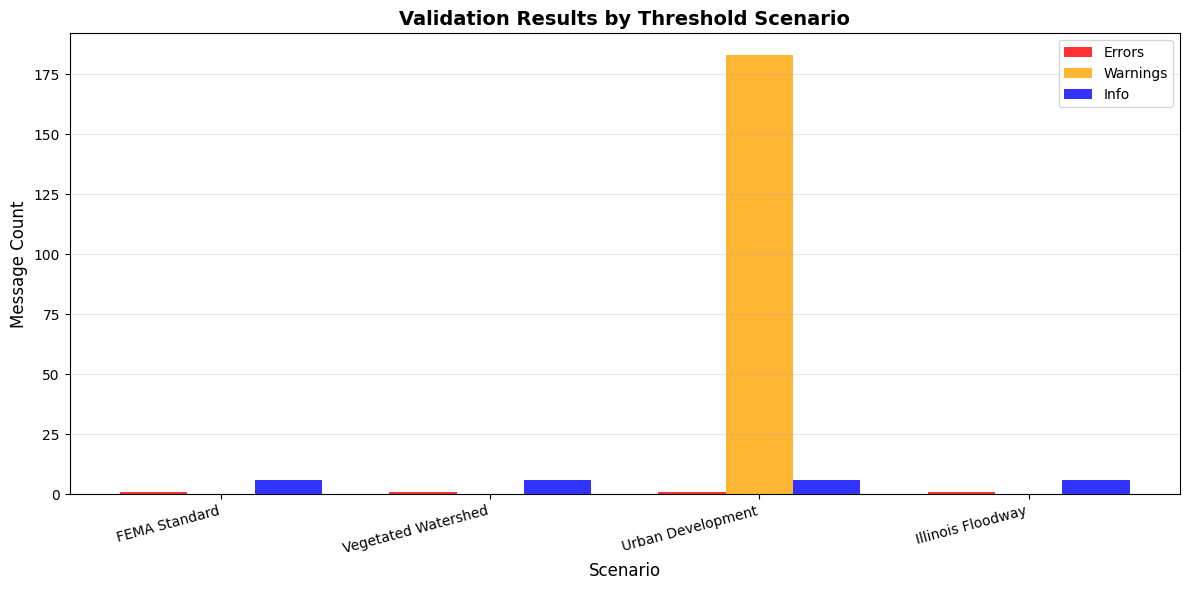

In [13]:
# Visualize scenario comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(df_comparison))
width = 0.25

ax.bar(x - width, df_comparison['Errors'], width, label='Errors', color='red', alpha=0.8)
ax.bar(x, df_comparison['Warnings'], width, label='Warnings', color='orange', alpha=0.8)
ax.bar(x + width, df_comparison['Info'], width, label='Info', color='blue', alpha=0.8)

ax.set_xlabel('Scenario', fontsize=12)
ax.set_ylabel('Message Count', fontsize=12)
ax.set_title('Validation Results by Threshold Scenario', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df_comparison['Scenario'], rotation=15, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Workflow 2: Batch Export to CSV

In [14]:
# Export all scenario results to CSV files
output_dir = project_path / "ras_checker" / "batch_results"
output_dir.mkdir(parents=True, exist_ok=True)

for scenario_name, results in scenario_results.items():
    # Create safe filename
    safe_name = scenario_name.replace(' ', '_').lower()
    csv_path = output_dir / f"{safe_name}_validation.csv"
    
    # Export to CSV
    df = results.to_dataframe()
    if not df.empty:
        df.to_csv(csv_path, index=False)
        print(f"✓ Exported {len(df)} messages to: {csv_path.name}")
    else:
        print(f"  No messages for {scenario_name}")

✓ Exported 7 messages to: fema_standard_validation.csv
✓ Exported 7 messages to: vegetated_watershed_validation.csv
✓ Exported 190 messages to: urban_development_validation.csv
✓ Exported 7 messages to: illinois_floodway_validation.csv


### Workflow 3: Automated Report Generation

In [15]:
# Generate HTML reports for all scenarios
for scenario_name, results in scenario_results.items():
    safe_name = scenario_name.replace(' ', '_').lower()
    report_path = output_dir / f"{safe_name}_report.html"
    
    metadata = ReportMetadata(
        project_name=f"{ras.project_name} - {scenario_name}",
        project_path=project_path,
        plan_name=f"Scenario: {scenario_name}"
    )
    
    results.to_html(report_path, metadata=metadata)
    print(f"✓ Generated report: {report_path.name}")

print(f"\n✓ All reports saved to: {output_dir}")

2025-12-29 11:18:36 - ras_commander.check.report - INFO - Generated HTML report: C:\GH\ras-commander\examples\example_projects\Muncie_802\ras_checker\batch_results\fema_standard_report.html
2025-12-29 11:18:36 - ras_commander.check.report - INFO - Generated HTML report: C:\GH\ras-commander\examples\example_projects\Muncie_802\ras_checker\batch_results\vegetated_watershed_report.html
2025-12-29 11:18:36 - ras_commander.check.report - INFO - Generated HTML report: C:\GH\ras-commander\examples\example_projects\Muncie_802\ras_checker\batch_results\urban_development_report.html
2025-12-29 11:18:36 - ras_commander.check.report - INFO - Generated HTML report: C:\GH\ras-commander\examples\example_projects\Muncie_802\ras_checker\batch_results\illinois_floodway_report.html


✓ Generated report: fema_standard_report.html
✓ Generated report: vegetated_watershed_report.html
✓ Generated report: urban_development_report.html
✓ Generated report: illinois_floodway_report.html

✓ All reports saved to: C:\GH\ras-commander\examples\example_projects\Muncie_802\ras_checker\batch_results


---

## Part 4: Advanced CSV Analysis

Analyze validation results using pandas for custom insights:

In [16]:
# Use FEMA standard results for analysis
results = scenario_results['FEMA Standard']
df = results.to_dataframe()

if not df.empty:
    print(f"Loaded {len(df)} validation messages for analysis")
    print(f"\nAvailable columns: {list(df.columns)}")
else:
    print("No messages available for analysis")

Loaded 7 validation messages for analysis

Available columns: ['message_id', 'severity', 'check_type', 'river', 'reach', 'station', 'structure', 'message', 'flagged', 'comment', 'value', 'threshold']


### Analysis 1: Identify Top Issues

In [17]:
if not df.empty:
    # Count issues by message ID
    top_issues = df['message_id'].value_counts().head(10)
    
    print("Top 10 Most Common Issues:")
    print("="*60)
    for msg_id, count in top_issues.items():
        severity = df[df['message_id'] == msg_id]['severity'].iloc[0]
        print(f"  [{severity}] {msg_id}: {count} occurrences")

Top 10 Most Common Issues:
  [INFO] US_MB_PASS: 1 occurrences
  [ERROR] US_CW_02: 1 occurrences
  [INFO] US_PE_INFO: 1 occurrences
  [INFO] US_PK_INFO: 1 occurrences
  [INFO] US_PK_PASS: 1 occurrences
  [INFO] US_INFO_01: 1 occurrences
  [INFO] US_INFO_02: 1 occurrences


### Analysis 2: Spatial Distribution of Issues

In [18]:
if not df.empty:
    # Group by river/reach
    if 'river' in df.columns and 'reach' in df.columns:
        spatial_summary = df.groupby(['river', 'reach']).agg({
            'message_id': 'count',
            'severity': lambda x: f"{(x=='ERROR').sum()}E / {(x=='WARNING').sum()}W"
        }).rename(columns={'message_id': 'Total Messages', 'severity': 'Breakdown'})
        
        print("\nIssues by River/Reach:")
        print("="*60)
        display(spatial_summary)


Issues by River/Reach:


,,Total Messages,Breakdown
river,reach,,
,,7,1E / 0W


### Analysis 3: Check Type Performance

In [19]:
if not df.empty:
    # Analyze by check type
    check_summary = df.groupby('check_type')['severity'].value_counts().unstack(fill_value=0)
    check_summary['Total'] = check_summary.sum(axis=1)
    check_summary = check_summary.sort_values('Total', ascending=False)
    
    print("\nValidation Results by Check Type:")
    print("="*60)
    display(check_summary)


Validation Results by Check Type:


severity,ERROR,INFO,Total
check_type,,,
UNSTEADY,1,6,7


---

## Part 5: Integration Patterns

### Pattern 1: Pre-Submission QA Workflow

In [20]:
def pre_submission_qa(plan_number, state_code='TX', output_folder=None):
    """
    Complete QA workflow for FEMA submission.
    
    Parameters
    ----------
    plan_number : str
        HEC-RAS plan number to validate
    state_code : str
        State code for appropriate surcharge limit
    output_folder : Path, optional
        Output folder for reports (default: project folder)
    
    Returns
    -------
    dict
        Summary of validation results
    """
    print(f"Running Pre-Submission QA for Plan {plan_number}")
    print(f"State: {state_code}")
    print("="*60)
    
    # 1. Get state-specific thresholds
    surcharge = get_state_surcharge_limit(state_code)
    thresholds = create_custom_thresholds({
        'floodway.surcharge_max_ft': surcharge
    })
    print(f"✓ Using {state_code} surcharge limit: {surcharge} ft")
    
    # 2. Run all checks
    results = RasCheck.run_all(plan_number, thresholds=thresholds)
    print(f"✓ Validation complete: {len(results.messages)} messages")
    
    # 3. Generate outputs
    if output_folder is None:
        output_folder = project_path / "qa_submission"
    output_folder.mkdir(parents=True, exist_ok=True)
    
    # HTML report
    html_path = output_folder / "validation_report.html"
    metadata = ReportMetadata(
        project_name=ras.project_name,
        project_path=project_path,
        plan_name=f"Plan {plan_number} - {state_code} Standards"
    )
    results.to_html(html_path, metadata=metadata)
    print(f"✓ HTML report: {html_path}")
    
    # CSV export
    csv_path = output_folder / "validation_messages.csv"
    df = results.to_dataframe()
    if not df.empty:
        df.to_csv(csv_path, index=False)
        print(f"✓ CSV export: {csv_path}")
    
    # 4. Return summary
    summary = {
        'plan': plan_number,
        'state': state_code,
        'total_messages': len(results.messages),
        'errors': results.get_error_count(),
        'warnings': results.get_warning_count(),
        'ready_for_submission': results.get_error_count() == 0
    }
    
    print("\n" + "="*60)
    print(f"QA Summary:")
    print(f"  Errors: {summary['errors']}")
    print(f"  Warnings: {summary['warnings']}")
    print(f"  Ready for submission: {summary['ready_for_submission']}")
    
    return summary

# Test the workflow using the PLAN parameter
summary = pre_submission_qa(PLAN, state_code="TX")

2025-12-29 11:18:36 - ras_commander.check.RasCheck - INFO - Detected flow type: unsteady
2025-12-29 11:18:36 - ras_commander.check.RasCheck - INFO - Running unsteady flow validation checks
2025-12-29 11:18:36 - ras_commander.hdf.HdfResultsPlan - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\Muncie_802\Muncie.p01.hdf
2025-12-29 11:18:36 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\Muncie_802\Muncie.p01.hdf
2025-12-29 11:18:36 - ras_commander.hdf.HdfResultsPlan - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\Muncie_802\Muncie.p01.hdf
2025-12-29 11:18:36 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\Muncie_802\Muncie.p01.hdf
2025-12-29 11:18:36 - ras_commander.hdf.HdfResultsPlan - INFO - Reading computation messages from HDF: Muncie.p01.hdf
2025-12-29 11:18:36 -

Running Pre-Submission QA for Plan 01
State: TX
✓ Using TX surcharge limit: 1.0 ft
✓ Validation complete: 7 messages
✓ HTML report: C:\GH\ras-commander\examples\example_projects\Muncie_802\qa_submission\validation_report.html
✓ CSV export: C:\GH\ras-commander\examples\example_projects\Muncie_802\qa_submission\validation_messages.csv

QA Summary:
  Errors: 1
  Warnings: 0
  Ready for submission: False


### Pattern 2: Continuous Monitoring During Model Development

In [21]:
def track_validation_progress(plan_number, iterations):
    """
    Track how validation improves over multiple model iterations.
    
    In practice, you would run this after each model revision.
    """
    progress = []
    
    for i in range(iterations):
        # In real use, model would be updated between iterations
        results = RasCheck.run_all(plan_number)
        
        progress.append({
            'Iteration': i + 1,
            'Total Messages': len(results.messages),
            'Errors': results.get_error_count(),
            'Warnings': results.get_warning_count()
        })
    
    return pd.DataFrame(progress)

# Simulate tracking (in practice, run after each model update)
progress_df = track_validation_progress(PLAN, iterations=1)
print("Validation Progress Tracking:")
display(progress_df)

2025-12-29 11:18:36 - ras_commander.check.RasCheck - INFO - Detected flow type: unsteady
2025-12-29 11:18:36 - ras_commander.check.RasCheck - INFO - Running unsteady flow validation checks
2025-12-29 11:18:36 - ras_commander.hdf.HdfResultsPlan - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\Muncie_802\Muncie.p01.hdf
2025-12-29 11:18:36 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\Muncie_802\Muncie.p01.hdf
2025-12-29 11:18:36 - ras_commander.hdf.HdfResultsPlan - INFO - Using existing Path object HDF file: C:\GH\ras-commander\examples\example_projects\Muncie_802\Muncie.p01.hdf
2025-12-29 11:18:36 - ras_commander.hdf.HdfResultsPlan - INFO - Final validated file path: C:\GH\ras-commander\examples\example_projects\Muncie_802\Muncie.p01.hdf
2025-12-29 11:18:36 - ras_commander.hdf.HdfResultsPlan - INFO - Reading computation messages from HDF: Muncie.p01.hdf
2025-12-29 11:18:36 -

Validation Progress Tracking:


,Iteration,Total Messages,Errors,Warnings
0,1,7,1,0


---

## Summary

This notebook demonstrated advanced RasCheck workflows:

### State Standards
- All 50 US states supported
- 7 states with stricter standards (IL: 0.1 ft, WI/MN/NJ/MI/IN/OH: 0.5 ft)
- Automatic limit lookup with `get_state_surcharge_limit()`

### Custom Thresholds
- Vegetated watershed configuration
- Urban development standards
- State-specific floodway limits
- Complete threshold customization

### Batch Processing
- Multiple threshold scenarios
- Automated CSV export
- Batch HTML report generation
- Comparative analysis

### Integration Patterns
- Pre-submission QA workflow
- Continuous monitoring during development
- Advanced CSV analysis

### Related Notebooks
- **300_quality_assurance_rascheck.ipynb** - Comprehensive RasCheck overview
- **301_advanced_structure_validation.ipynb** - Culvert and starting WSE checks